# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/study/Github/MLDL1/HW4

/content/drive/MyDrive/study/Github/MLDL1/HW4


In [3]:
import math
import random
from pathlib import Path
import sys
sys.path.insert(0,str(Path().absolute().joinpath("data")))

from data import prepareData

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


########### import yours ###########

####################################

BATCH_SIZE = 64

# TRAIN_RATIO: train dataset ratio, should be a float in (0, 0.8]
# (0.8-TRAIN_RATIO) will be used for valid dataset
TRAIN_RATIO = 0.6 

## Util

**Do NOT Modify** code blocks in this section

In [4]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
def train(model, iterator, optimizer, loss_fn, clip):
    
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):

        src = batch[0].to(device)
        trg = batch[1].to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        loss = loss_fn(output, trg)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [6]:
def evaluate(model, iterator, loss_fn):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch[0].to(device)
            trg = batch[1].to(device)

            output = model(src, trg)

            loss = loss_fn(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

## Dataset & Dataloader

**Do NOT Modify** code blocks in this section

In [7]:
MAX_LENGTH = 10
VALID_RATIO = 0.8-TRAIN_RATIO

SOS_token = 0
EOS_token = 1

In [134]:
class TranslateDataset(Dataset):
    def __init__(self, max_length=10, fra2eng=True):
        self.input_lang, self.output_lang, self.pairs = prepareData('eng', 'fra', max_length=max_length, reverse=fra2eng)
        self.max_length=max_length

        self.input_lang.addWord('PAD')
        self.output_lang.addWord('PAD')
        self.input_lang_pad = self.input_lang.word2index['PAD']
        self.output_lang_pad = self.output_lang.word2index['PAD']
        
        print("data example")
        print(random.choice(self.pairs))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        pair = self.pairs[idx]
        x, y = self._tensorsFromPair(pair)
        return x, y

    def _tensorFromSentence(self, lang, sentence):
        indexes = [lang.word2index[word] for word in sentence.split(' ')]
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

    def _tensorsFromPair(self, pair):
        input_tensor = self._tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self._tensorFromSentence(self.output_lang, pair[1])
        return (input_tensor, target_tensor)

    def collate_fn(self, data):
        x_batch = []; y_batch = []
        
        for x, y in data:
            if x.shape[0] < self.max_length-1:
                x = torch.cat([x, self.input_lang_pad*torch.ones((self.max_length-1 - x.shape[0], 1), dtype=x.dtype)])
            elif x.shape[0] > self.max_length-1:
                x = x[:self.max_length-1]
            if y.shape[0] < self.max_length-1:
                y = torch.cat([y, self.output_lang_pad*torch.ones((self.max_length-1 - y.shape[0], 1), dtype=y.dtype)])
            elif y.shape[0] > self.max_length-1:
                y = y[:self.max_length-1]

            x_batch.append(torch.cat([torch.tensor([SOS_token]), x.squeeze(1)]))
            y_batch.append(torch.cat([torch.tensor([SOS_token]), y.squeeze(1)]))
        
        return torch.stack(x_batch), torch.stack(y_batch)

dataset = TranslateDataset(max_length=MAX_LENGTH)

train_size = int(len(dataset)*TRAIN_RATIO)
valid_size = int(len(dataset)*VALID_RATIO)
train_data, valid_data, test_data = random_split(dataset, [train_size, valid_size, len(dataset)-(train_size+valid_size)],)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, collate_fn=dataset.collate_fn, shuffle=True)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
data example
['je suis votre medecin .', 'i m your doctor .']


# 1. Seq2Seq model with Attention Mechanism

## Implement LSTM Seq2Seq Model

In [136]:
class LSTMEncoder(nn.Module):
    
    def __init__(self, in_dim, emb_dim, hid_dim):
        super(LSTMEncoder, self).__init__()

        self.embedding = nn.Embedding(in_dim, emb_dim, padding_idx=dataset.input_lang.n_words-1)
        self.lstm = nn.LSTM(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)


    def forward(self, input, hidden, cell):
        '''
        Q2 - (a)
        Implement forward method of LSTM Encoder Module

        INPUT
        - input: input sentence, (B, max_len)
        - hidden: initialized hidden state, (1, B, hid_dim)
        - cell: initialized cell state, (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need.
        some examples below
        - hidden states of encoder

        '''
        ################### YOUR CODE ###################

        embedding = self.embedding(input) # shape = (B, max_len, emb_dim)
        # output shape = (B, max_len, hid_dim)
        # hidden_state shape = (B, hid_dim)
        # cell_state shape = (1, B, hid_dim)
        outputs, (hidden_state, cell_state) = self.lstm(embedding, (hidden, cell))

        return outputs, hidden_state[0], cell_state

        #################################################

In [143]:
class AttnLSTMDecoder(nn.Module):

    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        super(AttnLSTMDecoder, self).__init__()
        
        self.t = 0 # (t)th token decoder
        self.enc_hiddens = enc_hiddens # encoder output
        self.dropout = dropout
        
        self.embedding = nn.Embedding(out_dim, emb_dim, padding_idx=dataset.output_lang.n_words-1)
        self.lstm = nn.LSTM(emb_dim + hid_dim, hid_dim, batch_first=True, dropout=dropout)
        self.classifier = nn.Linear(hid_dim, out_dim)


    def forward(self, input, hidden, cell):
        '''
        Q2 - (a)
        Implement forward method of LSTM Decoder Module with dot-product attention

        INPUT
        - input: input words (B, 1)
        - hidden: previous hidden state (B, hid_dim)
        - cell: previous cell state (1, B, hid_dim)

        OUTPUT
        What to be returned depends on your implementation of LSTMSeq2Seq. (Q2 - (b))
        Feel free to return outputs you need.
        Some examples below
        - predicted token embedding (B, out_dim)
        - current hidden state
        - current cell state

        '''
        ################### YOUR CODE ###################

        # set query to calculate attention
        query = hidden.unsqueeze(2) # shape = (B, hid_dim, 1)
        keys = self.enc_hiddens # shape = (B, max_len, hid_dim)
        values = self.enc_hiddens.transpose(1,2) # shape = (B, hid_dim, max_len)

        softmax = nn.Softmax(dim=1)

        attention_coefficients = softmax(torch.bmm(keys, query)) # shape = (B, max_len, 1)
        
        attention_values = torch.bmm(values, attention_coefficients) # shape = (B, hid_dim, 1)

        attention_values = attention_values.transpose(1,2) # shape = (B, 1, hid_dim)

        embedding = self.embedding(input) # shape = (B, 1, emb_dim)

        attention_embedding = nn.Dropout(self.dropout)(torch.cat((embedding, attention_values), 2)) # shape = (B, 1, emb_dim+hid_dim)

        # output shape = (B, 1, hid_dim)
        # hidden_state shape = (1, B, hid_dim)
        # cell_state shape = (1, B, hid_dim)
        outputs, (curr_hidden, curr_cell) = self.lstm(attention_embedding, (hidden.unsqueeze(0), cell))
        outputs = outputs.transpose(0,1)

        log_softmax = nn.LogSoftmax(dim=1)

        predicted_embedding = log_softmax(self.classifier(outputs[0])) # shape = (B, out_dim)

        self.t += 1 # update time for each forward

        return predicted_embedding, curr_hidden[0], curr_cell

        #################################################


In [195]:
class LSTMSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(LSTMSeq2Seq, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = dropout
        
        self.encoder = LSTMEncoder(in_dim, emb_dim, hid_dim)
        self.decoder = AttnLSTMDecoder(emb_dim, hid_dim, out_dim, dropout)
        
    def forward(self, src, trg):
        '''
        Q2 - (b)
        Implement forward method of LSTM Seq2Seq Module
        (Decoder module should attend encoder's outputs using dot product.)
        
        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        - output of token prediction (B, out_dim, max_len)

        '''
        batch_size, mx_len = src.shape
        ################### YOUR CODE ###################

        # Encoder (start from zero-hidden & zero-cell states)
        init_hidden_state = init_cell_state = torch.zeros(1, batch_size, self.hid_dim).to(self.device)
        enc_outputs, hidden_state, cell_state = self.encoder(src, init_hidden_state, init_cell_state)
        
        # Decoder
        self.decoder.enc_hiddens = enc_outputs # set encoder's hidden states
        outputs = torch.zeros(mx_len, batch_size, dataset.output_lang.n_words).to(self.device) # to store each decoder's output
        
        x = trg[:,[0]].to(self.device)

        for t in range(1, mx_len): # for each t'th token, get decoder outputs
            output, hidden_state, cell_state = self.decoder(x, hidden_state, cell_state)
            outputs[t] = output
            x = trg[:,[t]].to(self.device)
        
        self.decoder.t=0 # after for loop, reset decoder's time to evaluate properly

        outputs = torch.permute(outputs, (1, 2, 0))

        return outputs
        
        ################### YOUR CODE ###################

## Training

In [125]:
'''
Q2 - (c)
Train your Seq2Seq model and plot losses and perplexities.
Upon successful training, the test perplexity should be less than 5.
You may use visualization libraries for plotting and modify training options such as hyperparameters and optimizer.

'''

'\nQ2 - (c)\nTrain your Seq2Seq model and plot losses and perplexities.\nUpon successful training, the test perplexity should be less than 5.\nYou may use visualization libraries for plotting and modify training options such as hyperparameters and optimizer.\n\n'

In [156]:
def plot_history(history):
    plt.figure(figsize=(3 * 13, 4))
    plt.subplot(1, 5, 1)
    plt.title("Training and Validation Loss")
    plt.plot(history['train_loss'], label="train_loss")
    plt.plot(history['val_loss'], label="val_loss")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 5, 2)
    plt.title("Training and Validation PPL")
    plt.plot(history['train_ppl'], label="train_ppl")
    plt.plot(history['val_ppl'], label="val_ppl")
    plt.xlabel("epoch")
    plt.ylabel("PPL")
    plt.legend()
    plt.show()

In [253]:
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 256
emb_dim = 256
dropout = 0.1
learning_rate=2.5e-4
N_EPOCHS = 50
valid_every=5
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(ignore_index = dataset.output_lang_pad)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


hyperparameters:
  hid_dim: 256
  emb_dim: 256
  dropout: 0.1
  learning rate: 0.00025
  n_epochs: 50
Epoch: 01
	Train Loss: 4.189 | Train PPL:  65.927
	 Val. Loss: 2.918 |  Val. PPL:  18.512
Epoch: 02
	Train Loss: 2.716 | Train PPL:  15.125
Epoch: 03
	Train Loss: 2.440 | Train PPL:  11.478
Epoch: 04
	Train Loss: 2.253 | Train PPL:   9.515
Epoch: 05
	Train Loss: 2.116 | Train PPL:   8.300
Epoch: 06
	Train Loss: 2.005 | Train PPL:   7.426
	 Val. Loss: 2.065 |  Val. PPL:   7.885
Epoch: 07
	Train Loss: 1.909 | Train PPL:   6.747
Epoch: 08
	Train Loss: 1.817 | Train PPL:   6.152
Epoch: 09
	Train Loss: 1.737 | Train PPL:   5.680
Epoch: 10
	Train Loss: 1.664 | Train PPL:   5.280
Epoch: 11
	Train Loss: 1.594 | Train PPL:   4.924
	 Val. Loss: 1.806 |  Val. PPL:   6.084
Epoch: 12
	Train Loss: 1.529 | Train PPL:   4.612
Epoch: 13
	Train Loss: 1.462 | Train PPL:   4.315
Epoch: 14
	Train Loss: 1.401 | Train PPL:   4.058
Epoch: 15
	Train Loss: 1.343 | Train PPL:   3.830
Epoch: 16
	Train Loss: 1.284

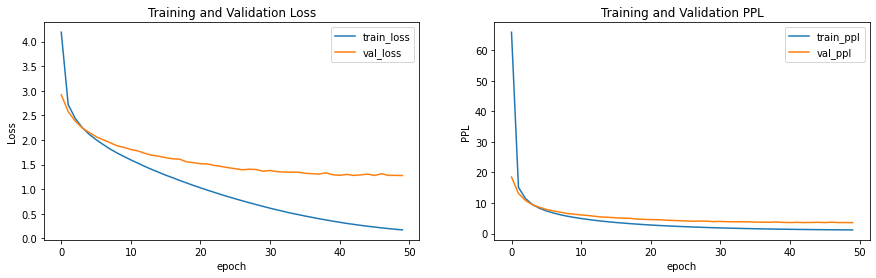

In [254]:
# Train your model
print(f'hyperparameters:\n  hid_dim: {hid_dim}\n  emb_dim: {emb_dim}\n  dropout: {dropout}\n  learning rate: {learning_rate}\n  n_epochs: {N_EPOCHS}')
history = {'train_loss':[], 'train_ppl':[], 'val_loss':[], 'val_ppl':[], 'lr':[]}

print("==========================")
for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_dataloader, optimizer, loss_fn, 1)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    valid_loss = evaluate(model, valid_dataloader, loss_fn)

    if epoch%valid_every==0:
        print("==========================")

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model.decoder.t=0
            torch.save(model.state_dict(), 'lstm-attn-model.pt')

        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(valid_loss)
    history['train_ppl'].append(math.exp(train_loss))
    history['val_ppl'].append(math.exp(valid_loss))
    history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history)

In [258]:
# Test your model

loaded_model = LSTMSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
loaded_model.load_state_dict(torch.load('lstm-attn-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


	 Test. Loss: 1.383 |  Test. PPL:   3.989


## [Bonus] Implement GRU Seq2Seq Model

In [ ]:
'''
Q2 - (d)
Change the modules(encoder, decoder) in Seq2Seq model to GRU, and repeat (a)~(c).

'''

In [214]:
class GRUEncoder(nn.Module):
    
    def __init__(self, in_dim, emb_dim, hid_dim):
        super(GRUEncoder, self).__init__()
        ################### YOUR CODE ###################

        self.embedding = nn.Embedding(in_dim, emb_dim, padding_idx=dataset.input_lang.n_words-1)
        self.gru = nn.GRU(input_size=emb_dim, hidden_size=hid_dim, num_layers=1, batch_first=True)

        #################################################

    def forward(self, input, hidden):

        ################### YOUR CODE ###################

        embedding = self.embedding(input) # shape = (B, max_len, emb_dim)
        # output shape = (B, max_len, hid_dim)
        # hidden_state shape = (B, hid_dim)
        outputs, hidden_state = self.gru(embedding, hidden)

        return outputs, hidden_state[0]
        
        #################################################

        

In [215]:
class AttnGRUDecoder(nn.Module):

    def __init__(self, emb_dim, hid_dim, out_dim, dropout, enc_hiddens=None):
        super(AttnGRUDecoder, self).__init__()
        
        ################### YOUR CODE ###################

        self.t = 0 # (t)th token decoder
        self.enc_hiddens = enc_hiddens # encoder output
        self.dropout = dropout
        
        self.embedding = nn.Embedding(out_dim, emb_dim, padding_idx=dataset.output_lang.n_words-1)
        self.gru = nn.GRU(emb_dim + hid_dim, hid_dim, batch_first=True, dropout=dropout)
        self.classifier = nn.Linear(hid_dim, out_dim)

        #################################################

    def forward(self, input, hidden):

        ################### YOUR CODE ###################

        # set query to calculate attention
        query = hidden.unsqueeze(2) # shape = (B, hid_dim, 1)
        keys = self.enc_hiddens # shape = (B, max_len, hid_dim)
        values = self.enc_hiddens.transpose(1,2) # shape = (B, hid_dim, max_len)

        softmax = nn.Softmax(dim=1)

        attention_coefficients = softmax(torch.bmm(keys, query)) # shape = (B, max_len, 1)
        
        attention_values = torch.bmm(values, attention_coefficients) # shape = (B, hid_dim, 1)

        attention_values = attention_values.transpose(1,2) # shape = (B, 1, hid_dim)

        embedding = self.embedding(input) # shape = (B, 1, emb_dim)

        attention_embedding = nn.Dropout(self.dropout)(torch.cat((embedding, attention_values), 2)) # shape = (B, 1, emb_dim+hid_dim)

        # output shape = (B, 1, hid_dim)
        # hidden_state shape = (1, B, hid_dim)
        # cell_state shape = (1, B, hid_dim)
        outputs, curr_hidden = self.gru(attention_embedding, hidden.unsqueeze(0))
        outputs = outputs.transpose(0,1)

        log_softmax = nn.LogSoftmax(dim=1)

        predicted_embedding = log_softmax(self.classifier(outputs[0])) # shape = (B, out_dim)

        self.t += 1 # update time for each forward

        return predicted_embedding, curr_hidden[0]

        #################################################


In [216]:
class GRUSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, emb_dim, hid_dim, device, dropout):
        super(GRUSeq2Seq, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.device = device
        self.dropout = dropout
        
        self.encoder = GRUEncoder(in_dim, emb_dim, hid_dim)
        self.decoder = AttnGRUDecoder(emb_dim, hid_dim, out_dim, dropout)
        
    def forward(self, src, trg):
        
        batch_size, mx_len = src.shape
        ################### YOUR CODE ###################
        
        # Encoder (start from zero-hidden & zero-cell states)
        init_hidden_state = torch.zeros(1, batch_size, self.hid_dim).to(self.device)
        enc_outputs, hidden_state = self.encoder(src, init_hidden_state)
        
        # Decoder
        self.decoder.enc_hiddens = enc_outputs # set encoder's hidden states
        outputs = torch.zeros(mx_len, batch_size, dataset.output_lang.n_words).to(self.device) # to store each decoder's output
        
        x = trg[:,[0]].to(self.device)

        for t in range(1, mx_len): # for each t'th token, get decoder outputs
            output, hidden_state = self.decoder(x, hidden_state)
            outputs[t] = output
            x = trg[:,[t]].to(self.device)
        
        self.decoder.t=0 # after for loop, reset decoder's time to evaluate properly

        outputs = torch.permute(outputs, (1, 2, 0))

        return outputs
        
        #################################################

In [275]:
# GRU hyperparameters
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 256
emb_dim = 256
dropout = 0.1
learning_rate=3.5e-4
N_EPOCHS = 50
valid_every=5
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gru_model = GRUSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)

optimizer = torch.optim.Adam(gru_model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss(ignore_index = dataset.output_lang_pad)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
# Train your model
print(f'hyperparameters:\n  hid_dim: {hid_dim}\n  emb_dim: {emb_dim}\n  dropout: {dropout}\n  learning rate: {learning_rate}\n  n_epochs: {N_EPOCHS}')
history = {'train_loss':[], 'train_ppl':[], 'val_loss':[], 'val_ppl':[], 'lr':[]}

print("==========================")
for epoch in range(N_EPOCHS):
    
    train_loss = train(gru_model, train_dataloader, optimizer, loss_fn, 1)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    valid_loss = evaluate(gru_model, valid_dataloader, loss_fn)

    if epoch%valid_every==0:
        print("==========================")

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            gru_model.decoder.t=0
            torch.save(gru_model.state_dict(), 'gru-attn-model.pt')

        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    history['train_loss'].append(train_loss)
    history['val_loss'].append(valid_loss)
    history['train_ppl'].append(math.exp(train_loss))
    history['val_ppl'].append(math.exp(valid_loss))
    history['lr'].append(optimizer.param_groups[0]['lr'])

plot_history(history)

hyperparameters:
  hid_dim: 256
  emb_dim: 256
  dropout: 0.1
  learning rate: 0.00035
  n_epochs: 50
Epoch: 01
	Train Loss: 3.713 | Train PPL:  40.978
	 Val. Loss: 2.747 |  Val. PPL:  15.595
Epoch: 02
	Train Loss: 2.553 | Train PPL:  12.840
Epoch: 03
	Train Loss: 2.211 | Train PPL:   9.123
Epoch: 04
	Train Loss: 1.984 | Train PPL:   7.270
Epoch: 05
	Train Loss: 1.826 | Train PPL:   6.208
Epoch: 06
	Train Loss: 1.699 | Train PPL:   5.468
	 Val. Loss: 1.850 |  Val. PPL:   6.357
Epoch: 07
	Train Loss: 1.594 | Train PPL:   4.924
Epoch: 08
	Train Loss: 1.497 | Train PPL:   4.466
Epoch: 09
	Train Loss: 1.407 | Train PPL:   4.085
Epoch: 10
	Train Loss: 1.328 | Train PPL:   3.772
Epoch: 11
	Train Loss: 1.253 | Train PPL:   3.500
	 Val. Loss: 1.611 |  Val. PPL:   5.006


In [274]:
loaded_model = GRUSeq2Seq(in_dim, out_dim, emb_dim, hid_dim, device, dropout).to(device)
loaded_model.load_state_dict(torch.load('gru-attn-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {test_loss:.3f} |  Test. PPL: {math.exp(test_loss):7.3f}')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


	 Test. Loss: 1.453 |  Test. PPL:   4.274


# 2. Seq2Seq model with Transformer

## Implement Transformer Seq2Seq Model

In [ ]:
class TransEncoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, ff_dim, dropout, device, max_length = MAX_LENGTH):
        super().__init__()

        self.hid_dim = hid_dim
        self.max_length = max_length

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        
        encoder_layer = TransformerEncoderLayer(hid_dim, n_heads, ff_dim, dropout, batch_first=True)
        self.encoder = TransformerEncoder(encoder_layer, n_layers)
        
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor([hid_dim], device = device, dtype=torch.float32))
        
    def forward(self, src, pos_emb, src_mask):
        '''
        Q3 - (c)
        Implement forward method of TransEncoder Module
        (Use torch.nn.TransformerEncoder, torch.nn.TransformerEncoderLayer)
        
        INPUT
        - src: source language batched data (B, max_len)
        - pos_emb: positional embedding (max_len, hid_dim)
        - src_mask: padding mask tensor for source sentences (B, max_len)

        OUTPUT
        What to be returned depends on your implementation of TransSeq2Seq.
        Feel free to return outputs you need.
        Some examples below,

        - encoder output (B, max_len, hid_dim)
        '''
        batch_size, src_len = src.shape
        #################### YOUR CODE ####################

        
        return None
        ###################################################

In [ ]:
class TransDecoder(nn.Module):
    def __init__(self, out_dim, hid_dim, n_layers, n_heads, ff_dim, dropout, device, max_length = MAX_LENGTH):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.max_length = max_length
        
        self.tok_embedding = nn.Embedding(out_dim, hid_dim)
        
        decoder_layer = TransformerDecoderLayer(hid_dim, n_heads, ff_dim, dropout, batch_first=True)
        self.decoder = TransformerDecoder(decoder_layer, n_layers)
        
        self.fc_out = nn.Linear(hid_dim, out_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.tensor([hid_dim], device = device, dtype=torch.float32))
        
    def forward(self, trg, pos_emb, enc_src, trg_mask, trg_sub_mask, src_mask):
        '''
        Q3 - (c)
        Implement forward method of TransDecoder Module
        (Use torch.nn.TransformerDecoder, torch.nn.TransformerDecoderLayer)
        
        INPUT
        - trg: target language batched data (B, max_len)
        - pos_emb: positional embedding (max_len, hid_dim)
        - enc_src: encoder outputs (B, max_len, hid_dim)
        - trg_mask: padding mask tensor for target sentences (B, max_len)
        - trg_sub_mask: subsequent mask for target sentences (max_len, max_len)
        - src_mask: padding mask tensor for source sentences (B, max_len)

        OUTPUT
        What to be returned depends on your implementation of TransSeq2Seq.
        Feel free to return outputs you need.
        Some examples below,

        - decoder output (B, max_len, out_dim)
        '''
        batch_size, trg_len = trg.shape

        #################### YOUR CODE ####################
        
        return None
        ###################################################

In [ ]:
class TransSeq2Seq(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout_p, device, max_length=MAX_LENGTH):
        super().__init__()
        
        self.device = device
        self.hid_dim = hid_dim
        self.max_length = max_length

        self.encoder = TransEncoder(in_dim, hid_dim, n_layers[0], n_heads, ff_dim, dropout_p, device)
        self.decoder = TransDecoder(out_dim, hid_dim, n_layers[1], n_heads, ff_dim, dropout_p, device)
        
    def make_src_mask(self, src):
        '''
        Q3 - (b)
        Implement mask generating function

        INPUT
        - src: batched input sentences (B, max_len)

        OUTPUT
        - Boolean padding mask tensor (B, max_len)
        '''
        #################### YOUR CODE ####################
        
        return None
        ###################################################

    def make_trg_mask(self, trg):
        '''
        Q3 - (b)
        Implement mask generating function

        INPUT
        - trg: batched target sentences (B, max_len)

        OUTPUT
        - A tuple of a padding mask tensor and a subsequent mask tensor ((B, max_len), (max_len, max_len))
        '''
        #################### YOUR CODE ####################

        return None
        ###################################################

    def forward(self, src, trg):
        '''
        Q3 - (c)
        Implement forward method of TransSeq2Seq Module
        
        INPUT
        - src: source language batched data (B, max_len)
        - trg: target language batched data (B, max_len)

        OUTPUT
        - decoder output (B, out_dim, max_dim)
        
        '''
        #################### YOUR CODE ####################

        return None
        ###################################################
    
    
    def get_pos_emb(self):
        '''
        Q3 - (a)
        Implement absolute positional embedding

        OUTPUT
        - positional embedding tensor (max_len, hid_dim)
        '''
        #################### YOUR CODE ####################

        return None
        ###################################################

## Training

In [ ]:
'''
Q3 - (d)
Train your Seq2Seq model and plot losses and perplexities.
Upon successful training, the test perplexity should be less than 2.
You may use visualization libraries for plotting and modify training options such as hyperparameters and optimizer.

Based on the results from lSTM(GRU)-based and transformer-based Seq2Seq models,
briefly describe which approach is better and why.
'''

In [ ]:
in_dim = dataset.input_lang.n_words
out_dim = dataset.output_lang.n_words
hid_dim = 256
ff_dim = 1024
n_enc_layers = 4
n_dec_layers = 4
n_layers = [n_enc_layers, n_dec_layers]
n_heads = 8
dropout = 0.1

learning_rate=1e-2
N_EPOCHS = 100
valid_every=5
best_valid_loss = float('inf')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransSeq2Seq(in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout, device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.output_lang_pad)
# print(model)

In [ ]:
# Train your model
for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_dataloader, optimizer, loss_fn, 1)
    
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    
    if epoch%valid_every==0:
        print("==========================")
        valid_loss = evaluate(model, valid_dataloader, loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            model.decoder.t=0
            torch.save(model.state_dict(), 'transformer-model.pt')

        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# Test your model
loaded_model = TransSeq2Seq(in_dim, out_dim, hid_dim, ff_dim, n_layers, n_heads, dropout, device).to(device)
loaded_model.load_state_dict(torch.load('transformer-model.pt'))

test_loss = evaluate(loaded_model, test_dataloader, loss_fn)
print(f'\t Test. Loss: {valid_loss:.3f} |  Test. PPL: {math.exp(valid_loss):7.3f}')